In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [5]:
x_data = np.loadtxt('x_testdata.txt')
y_data = np.loadtxt('y_testdata.txt')

x_data = torch.from_numpy(x_data)
y_data = torch.from_numpy(y_data)

In [6]:
class PlanarFlowCorrected(nn.Module):
    def __init__(self, dim):
        super(PlanarFlowCorrected, self).__init__()
        self.u = nn.Parameter(torch.randn(dim))
        self.w = nn.Parameter(torch.randn(dim))
        self.b = nn.Parameter(torch.randn(1))
        
    def forward(self, z):
        tanh_term = torch.tanh(z @ self.w.unsqueeze(-1) + self.b)
        psi = (1 - tanh_term ** 2) * self.w
        det_jacobian = torch.abs(1 + psi @ self.u)
        f_z = z + self.u * tanh_term
        return f_z, det_jacobian

# Corrected planar flow
dim = 2
planar_flow_corrected = PlanarFlowCorrected(dim)

# Quick test to check the transformation
z_sample = torch.randn(10, 2)

transformed_corrected, _ = planar_flow_corrected(z_sample)

transformed_corrected.shape

torch.Size([10, 2])

In [27]:
# Define the training function for the normalizing flow
def train_normalizing_flow(flow, data, epochs=1000, lr=0.01):
    optimizer = torch.optim.Adam(flow.parameters(), lr=lr)
    base_dist = torch.distributions.Normal(0, 1)
    
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Sample from the base distribution
        z0 = base_dist.sample((data.shape[0], dim))
        
        # Apply the normalizing flow transformation
        zk, det_jacobian = flow(z0)
        
        # Compute the log likelihood of the transformed samples
        log_likelihood = base_dist.log_prob(z0).sum(1) + torch.log(det_jacobian)
        loss = -torch.mean(log_likelihood)
        
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        
        if (epoch + 1) % 200 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")
    
    return flow, losses

# Training data (the provided x and y data points)
data = torch.stack([x_data, y_data], dim=1)

# Train the normalizing flow
trained_flow, training_losses = train_normalizing_flow(planar_flow_corrected, data/data.max(), epochs=20000, lr=0.0001)

training_losses[-5:]  # Display the last 5 loss values for brevity


Epoch 200/20000, Loss: -0.2771
Epoch 400/20000, Loss: -0.4390
Epoch 600/20000, Loss: 0.1376
Epoch 800/20000, Loss: -0.5044
Epoch 1000/20000, Loss: -0.6611
Epoch 1200/20000, Loss: -0.3082
Epoch 1400/20000, Loss: 0.0611
Epoch 1600/20000, Loss: 0.0927
Epoch 1800/20000, Loss: -0.8250
Epoch 2000/20000, Loss: -0.0896
Epoch 2200/20000, Loss: -0.0937
Epoch 2400/20000, Loss: -0.3303
Epoch 2600/20000, Loss: -0.1814
Epoch 2800/20000, Loss: -0.2429
Epoch 3000/20000, Loss: -0.4575
Epoch 3200/20000, Loss: -0.1792
Epoch 3400/20000, Loss: 0.0307
Epoch 3600/20000, Loss: 0.0938
Epoch 3800/20000, Loss: -0.5925
Epoch 4000/20000, Loss: -0.2386
Epoch 4200/20000, Loss: -0.3648
Epoch 4400/20000, Loss: -0.3912
Epoch 4600/20000, Loss: 0.1221
Epoch 4800/20000, Loss: -0.3920
Epoch 5000/20000, Loss: -0.3033
Epoch 5200/20000, Loss: -0.1849
Epoch 5400/20000, Loss: -0.0950
Epoch 5600/20000, Loss: -0.0236
Epoch 5800/20000, Loss: 0.3621
Epoch 6000/20000, Loss: -0.8164
Epoch 6200/20000, Loss: 0.0013
Epoch 6400/20000, Lo

[-0.6468933820724487,
 -0.7495127320289612,
 -0.6434693932533264,
 -0.5151106119155884,
 -0.014835527166724205]

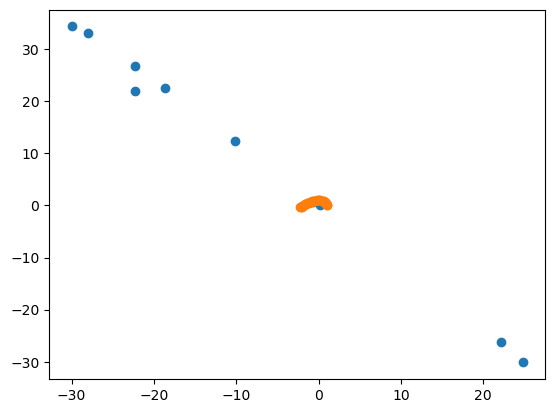

In [28]:
out = trained_flow.forward(torch.randn(10, 2))
plt.scatter(out[0][:,0].detach().numpy(),out[0][:,1].detach().numpy())
plt.scatter(x_data/x_data.max(),y_data/y_data.max())